# Gather list of MICCAI papers
We can't distinguish papers from MICCAI using only OpenAlex, therefore we've used the API of [dblp.org](dblp.org) to get them.

We have to query an url similar to https://dblp.org/search/publ/api?q=stream%3Aconf%2Fmiccai%3A%20streamid%3Aconf%2Fmiccai%3A%20type%3AConference_and_Workshop_Papers%3A&h=1000&f=1000&format=json

We iterate through f value, as we can only get 1000 papers from a query, the f parameter indicates at which paper the result starts


## Get list of papers

In [6]:
import requests
indice_paper = 0
nextPage = True
#Dictionnary with doi as key and title as value
lst_paper = {}
while nextPage:
    request_url = f"https://dblp.org/search/publ/api?q=stream%3Aconf%2Fmiccai%3A%20streamid%3Aconf%2Fmiccai%3A%20type%3AConference_and_Workshop_Papers%3A&h=1000&f={indice_paper}&format=json"
    request = requests.get(request_url)
    if request.status_code == 200:
        r_json = request.json()
        if r_json["result"]["hits"]["@sent"] != '0':
            for paper in r_json["result"]["hits"]["hit"]:
                if "doi" not in paper["info"] or "title" not in paper["info"] or int(paper["info"]["year"]) < 2013 or paper["info"]["venue"] != "MICCAI":
                    continue
                title = paper["info"]["title"]
                title = title.replace(",","")
                title = title.replace("\n","")
                year = paper["info"]["year"]
                venue = paper["info"]["venue"]
                doi = paper["info"]["doi"]
                lst_paper[doi] = title
            indice_paper += 1000
        else:
            nextPage = False
        
            

## Save it in a csv
So we don't need to query again the API

In [7]:
import csv
with open('../../data/miccai_papers.csv','w') as f:
    f.write("doi,title")
    for k in lst_paper:
        f.write(f"\n{k},{lst_paper[k]}")

# Request OpenAlex
For each paper obtained above, we use its API to query OpenAlex and check if a dataset is in the references. Then we apply the wrong reference detection process

In [5]:
import numpy as np
"""
Reconstruct and transform the abstract of a paper using abstract_inverted_index field. We will removed non alpha numeric caracters and lower every word.
"""
def reconstruct_abstract(paper):
    # Maximum size of the abstract, if the paper abstarct is longer it will be truncated
    abstract = np.full(2500,"",dtype=object)
    # The "abstract_inverted_index" field is a dictionnary with word as key and locations of this word in the abstract
    # So we fill the abstarct variable above at the index of the word to reconstruct the abstract
    if paper[3]:
        for w in paper[3]:
            for indices in paper[3][w]:
                if indices < 2500:
                    abstract[indices] = ''.join(filter(str.isalnum, w)).lower()
        # Remove empty location mostly due to a shorter abstract 
        abstract = abstract[abstract != ""]
        #Convert array to string
    str_abstract = ' '.join(abstract)
    return str_abstract

### Load list of papers and datasets

In [1]:
import csv
import requests
lst_paper = {}
reader = csv.DictReader(open('../../data/miccai_papers.csv'))
for paper in reader:
    lst_paper[paper["doi"]] = paper["title"]

#Dictionnary with dataset's name as key and DOI as value
datasets_doi = {}
ds_reader = csv.DictReader(open('../../data/datasets.csv'))
for ds in ds_reader:
    datasets_doi[ds["name"]] = ds["DOI"]

"""
Convert a DOI to OpenAlex ID used as value in some API field such as "referenced_works"
@param
    - DOI: the doi we want to convert
@return
    The OpenAlex ID if the DOI is in OpenAlex database, None otherwise
"""
def doi_to_OpenAlexId(doi):
    base_url = f"https://api.openalex.org/works/doi:{doi}"
    r = requests.get(base_url)
    if r.status_code == 200:
        r_json = r.json()
        return r_json["id"]
    else:
        return None

#Dictionnary with dataset names as key and openalex id as value. We associate an openalex ID because it's the value in the "referenced_works" field given by the API.
datasets_id = {}

#Convert DOI to OpenAlexID
for ds  in datasets_doi:
    openalex_id = doi_to_OpenAlexId(datasets_doi[ds])
    if not openalex_id:
        print(f"Couldn't convert DOI for {ds} into OpenAlex ID")
    datasets_id[ds]=openalex_id

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
datasets_id

{'ACDC': 'https://openalex.org/W2804047627',
 'sunnybrook': 'https://openalex.org/W4205182665',
 'STACOM’11': 'https://openalex.org/W1491198555',
 'RVSC': 'https://openalex.org/W2057441779',
 'M&Ms': 'https://openalex.org/W4226199676'}

### Query OpenAlex for each paper

In [4]:
from tqdm import tqdm
from collections import Counter
paper_referencing = {ds:[] for ds in datasets_id}
errors = Counter()
nb_pymed = 0
for doi in tqdm(lst_paper):
    title = lst_paper[doi]
    request_url = f"https://api.openalex.org/works/doi:{doi}"
    request = requests.get(request_url)
    if request.status_code == 200:
        r_json = request.json()
        fulltext_url = r_json["open_access"]["oa_url"]
        pmid = None
        #Remove review/survey paper
        if "review" in title.lower() or "survey" in title.lower():
            continue
        if "pmid" in r_json["ids"]:
            nb_pymed += 1
            pmid = r_json["ids"]["pmid"]
        for ds in paper_referencing:
            if datasets_id[ds] in r_json["referenced_works"]:
                paper_referencing[ds].append((title,doi,r_json["publication_year"],r_json["abstract_inverted_index"],fulltext_url,pmid))
    else:
        errors[request.status_code] += 1

100%|██████████| 3839/3839 [29:01<00:00,  2.20it/s]


In [6]:
from tqdm import tqdm
from collections import Counter
paper_in_abstract = {ds:[] for ds in datasets_id}
errors = Counter()
nb_pymed = 0
for doi in tqdm(lst_paper):
    title = lst_paper[doi]
    request_url = f"https://api.openalex.org/works/doi:{doi}"
    request = requests.get(request_url)
    if request.status_code == 200:
        r_json = request.json()
        fulltext_url = r_json["open_access"]["oa_url"]
        pmid = None
        #Remove review/survey paper
        if "review" in title.lower() or "survey" in title.lower():
            continue
        paper = (title,doi,r_json["publication_year"],r_json["abstract_inverted_index"],fulltext_url,pmid)
        abstract = reconstruct_abstract(paper)
        
        for ds in paper_in_abstract:
            if ds.lower() in abstract:
                paper_in_abstract[ds].append(paper[1])
    else:
        errors[request.status_code] += 1

100%|██████████| 3839/3839 [30:39<00:00,  2.09it/s]   


In [8]:
for d in paper_in_abstract:
    print(f"Number of citations for {d}: {len(paper_in_abstract[d])}")

Number of citations for ACDC: 14
Number of citations for sunnybrook: 1
Number of citations for STACOM’11: 0
Number of citations for RVSC: 0
Number of citations for M&Ms: 0


In [17]:
for d in paper_referencing:
    print(f"Number of citations for {d}: {len(paper_referencing[d])}")

Number of citations for ACDC: 40
Number of citations for sunnybrook: 5
Number of citations for STACOM’11: 0
Number of citations for RVSC: 1
Number of citations for M&Ms: 8


In [13]:
import csv
with open('./ref_miccai.csv','w') as f:
    f.write("doi,title,dataset")
    for d in paper_referencing:
        for p in paper_referencing[d]:
            f.write(f"\n{p[1]},{p[0]},{d}")

## Apply pipeline

### Abstract

In [26]:
paper_using_abstract = {dataset:[] for dataset in paper_referencing}
for dataset in paper_referencing:
    for paper in paper_referencing[dataset]:
        abstract = reconstruct_abstract(paper)
        if dataset.lower() in abstract:
            paper_using_abstract[dataset].append(paper[1])

In [27]:
for d in paper_using_abstract:
    paper_using_abstract[d] = set(paper_using_abstract[d])
    print(f"Number of citations for {d}: {len(paper_using_abstract[d])}")

Number of citations for ACDC: 8
Number of citations for sunnybrook: 1
Number of citations for STACOM’11: 0
Number of citations for RVSC: 0
Number of citations for M&Ms: 0


### Download paper's fulltexts

In [3]:
import glob
downloaded_doi = []
title_to_doi = {}
#Already downloaded pdf
pdf_path = glob.glob("../../results/papers_fulltext/miccai/*.pdf")

In [37]:
paper_using_abstract

{'ACDC': {'10.1007/978-3-030-32245-8_3',
  '10.1007/978-3-030-59710-8_10',
  '10.1007/978-3-030-59719-1_38',
  '10.1007/978-3-030-87196-3_42',
  '10.1007/978-3-031-16443-9_4',
  '10.1007/978-3-031-16452-1_16',
  '10.1007/978-3-031-16452-1_22',
  '10.1007/978-3-031-16452-1_51'},
 'sunnybrook': {'10.1007/978-3-030-00937-3_64'},
 'STACOM’11': set(),
 'RVSC': set(),
 'M&Ms': set()}

In [4]:
from pypdf import PdfReader
from pypdf.errors import PdfReadError
paper_using_abstract = {dataset:[] for dataset in paper_referencing}

for dataset in paper_referencing:
    for paper in tqdm(paper_referencing[dataset]):
        title = paper[0].replace('/','')
        doi = paper[1]
        fulltext_url = paper[4]
        file_path = f"../../results/papers_fulltext/miccai/{title}.pdf"

        if title not in title_to_doi:
            title_to_doi[title]=doi
        if not fulltext_url:
            continue
        if file_path in pdf_path:
            continue
        if not paper[1] in paper_using_abstract[dataset]:
            #Check that paper hasn't been downloaded before (for another dataset), otherwise try to download it
            if doi not in downloaded_doi:
                try:
                    r_fulltext = requests.get(fulltext_url,allow_redirects=True,timeout=10)
                    pdf_content = r_fulltext.content
                    if r_fulltext.status_code == 200:
                        open(file_path,"wb").write(r_fulltext.content)
                        downloaded_doi.append(doi)
                    else:
                        continue
                except requests.exceptions.RequestException as ce:
                    continue
            try:
                #Try to read the pdf (Raise an error if the file is an invalid pdf)
                PdfReader(file_path,strict=True)
            except PdfReadError:
                #If a PdfReadError is raised, the pdf is invalid and therefore removed from downloaded list
                downloaded_doi.remove(doi)
                continue


 79%|███████▉  | 3043/3838 [32:07<15:53,  1.20s/it]Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
Xref table not zero-indexed. ID numbers for objects will be corrected.
 80%|████████  | 3076/3838

In [5]:
print(f"Number of downloaded fulltext: {len(downloaded_doi)}")

Number of downloaded fulltext: 2149


In [6]:
pdf_path = glob.glob("../../results/papers_fulltext/miccai/*.pdf")

In [7]:
import camelot
import ghostscript
paper_using_tables = {dataset:[] for dataset in paper_referencing}
for pdf in tqdm(pdf_path):
    try:
        tables = camelot.read_pdf(pdf,"all",flavor="stream",suppress_stdout=True)
        title= pdf.split("/")[-1].removesuffix(".pdf")
        for t in tables:
            t_str = t.df.to_string()
            for dataset in paper_using_tables:
                if dataset.lower() in t_str.lower():
                    paper_using_tables[dataset].append(title_to_doi[title])
    except:
        continue           

  1%|          | 23/2290 [00:54<1:31:31,  2.42s/it]invalid pdf header: b'\n\n<!D'
EOF marker not found
  2%|▏         | 45/2290 [02:00<2:04:55,  3.34s/it]invalid pdf header: b'\n\n<!D'
EOF marker not found
  2%|▏         | 52/2290 [02:15<1:33:18,  2.50s/it]Object 229 0 not defined.
Object 418 0 not defined.
Object 593 0 not defined.
  2%|▏         | 54/2290 [02:20<1:37:42,  2.62s/it]invalid pdf header: b'\n\n<!D'
EOF marker not found
  3%|▎         | 63/2290 [02:45<2:05:01,  3.37s/it]invalid pdf header: b'\n\n<!D'
EOF marker not found
invalid pdf header: b'<html'
EOF marker not found
  6%|▌         | 137/2290 [06:33<1:57:39,  3.28s/it]invalid pdf header: b'\n\n<!D'
EOF marker not found
  8%|▊         | 181/2290 [08:48<1:43:22,  2.94s/it]invalid pdf header: b'\n\n<!D'
EOF marker not found
 10%|▉         | 226/2290 [10:50<1:36:07,  2.79s/it]invalid pdf header: b'<!DOC'
EOF marker not found
 11%|█         | 255/2290 [12:04<1:25:10,  2.51s/it]invalid pdf header: b'\n\n<!D'
EOF marker not f

In [8]:
for d in paper_using_tables:
    paper_using_tables[d] = set(paper_using_tables[d])
    print(f"Number of citations for {d}: {len(paper_using_tables[d])}")

Number of citations for ACDC: 42
Number of citations for sunnybrook: 7
Number of citations for STACOM’11: 1
Number of citations for RVSC: 1
Number of citations for M&Ms: 13


In [85]:
confirmation_method = [paper_using_abstract,paper_using_tables]
paper_confirmed = {dataset:[] for dataset in paper_referencing}
for outcome in confirmation_method:
    for dataset in outcome:
        for paper in outcome[dataset]:
            paper_confirmed[dataset].append(paper)
for d in paper_confirmed:
    print(f"Number of citations for {d}: {len(paper_confirmed[d])}")
    paper_confirmed[d] = set(paper_confirmed[d])
    print(f"Number of citations for {d}: {len(paper_confirmed[d])}")


Number of citations for ACDC: 33
Number of citations for ACDC: 28
Number of citations for LA: 104
Number of citations for LA: 101
Number of citations for MSCMR: 3
Number of citations for MSCMR: 3
Number of citations for M&Ms: 8
Number of citations for M&Ms: 8
Number of citations for PROMISE12: 15
Number of citations for PROMISE12: 13
Number of citations for I2CVB: 1
Number of citations for I2CVB: 1
Number of citations for BRATS: 81
Number of citations for BRATS: 58
Number of citations for Synapse: 1
Number of citations for Synapse: 1


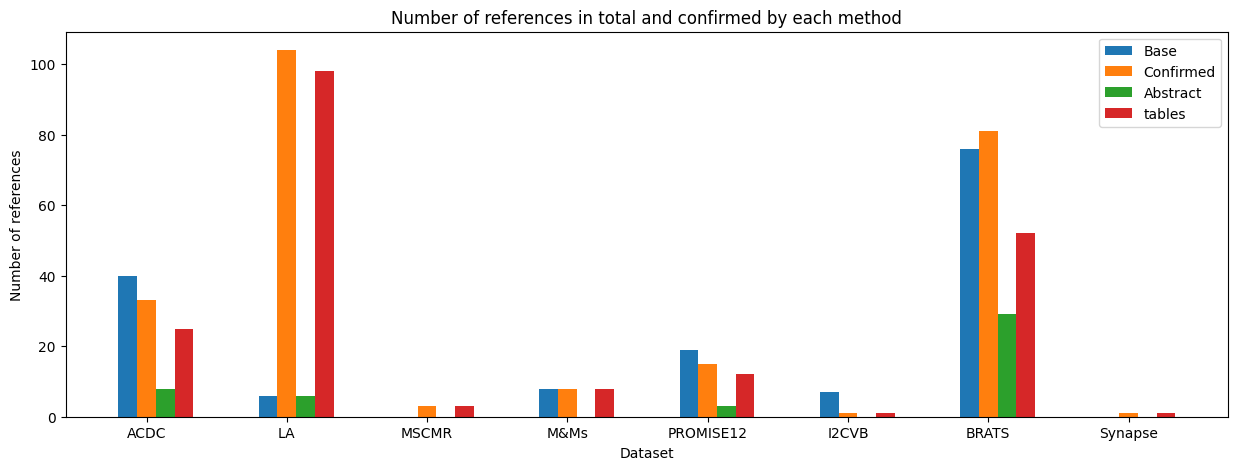

Base number of citation for ACDC: 40
Number of confirmed citations for ACDC: 33
Number of confirmed citations with abstract for ACDC: 8
Number of confirmed citations with tables for ACDC: 25

Base number of citation for LA: 6
Number of confirmed citations for LA: 104
Number of confirmed citations with abstract for LA: 6
Number of confirmed citations with tables for LA: 98

Base number of citation for MSCMR: 0
Number of confirmed citations for MSCMR: 3
Number of confirmed citations with abstract for MSCMR: 0
Number of confirmed citations with tables for MSCMR: 3

Base number of citation for M&Ms: 8
Number of confirmed citations for M&Ms: 8
Number of confirmed citations with abstract for M&Ms: 0
Number of confirmed citations with tables for M&Ms: 8

Base number of citation for PROMISE12: 19
Number of confirmed citations for PROMISE12: 15
Number of confirmed citations with abstract for PROMISE12: 3
Number of confirmed citations with tables for PROMISE12: 12

Base number of citation for I2

In [46]:
import matplotlib.pyplot as plt
X = list(paper_confirmed.keys())
nb_ref = [len(paper_referencing[x]) for x in X]
nb_confirmed = [len(paper_confirmed[x]) for x in X]
nb_abstract = [len(paper_using_abstract[x]) for x in X]
nb_tables = [len(paper_using_tables[x]) for x in X]

X_axis = np.arange(0,len(X)*3,3)

plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.4, nb_ref, 0.4, label = 'Base')
plt.bar(X_axis, nb_confirmed, 0.4, label = 'Confirmed')
plt.bar(X_axis + 0.4, nb_abstract, 0.4, label = 'Abstract')
plt.bar(X_axis + 0.8, nb_tables, 0.4, label = 'tables')
  
plt.xticks(X_axis, X)
plt.xlabel("Dataset")
plt.ylabel("Number of references")
plt.title("Number of references in total and confirmed by each method")
plt.legend()
plt.show()

for d in paper_confirmed:
    print(f"Base number of citation for {d}: {len(paper_referencing[d])}")
    print(f"Number of confirmed citations for {d}: {len(paper_confirmed[d])}")
    print(f"Number of confirmed citations with abstract for {d}: {len(paper_using_abstract[d])}")
    print(f"Number of confirmed citations with tables for {d}: {len(paper_using_tables[d])}\n")